In [1]:
import sys
import os
import logging

# Suppress TensorFlow / XLA logs before importing TF or src
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)
try:
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)
except ImportError:
    pass

import subprocess

REPO_URL = "https://github.com/mociatto/EcoFair.git"
REPO_DIR = "EcoFair"

if os.path.exists("./src"):
    sys.path.insert(0, os.path.abspath("."))
elif os.path.exists(os.path.join(".", REPO_DIR, "src")):
    sys.path.insert(0, os.path.abspath(REPO_DIR))
else:
    subprocess.run(["git", "clone", "--depth", "1", REPO_URL, REPO_DIR], check=True)
    sys.path.insert(0, os.path.abspath(REPO_DIR))

from src import config, utils, data_loader, models, training, features, routing, fairness, visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Cloning into 'EcoFair'...
E0000 00:00:1771691049.780810      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771691049.836350      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771691050.291891      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771691050.291943      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771691050.291946      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771691050.291948      23 computation_placer.cc:177] computation placer already regi

In [2]:
META_PATH = '/kaggle/input/datasets/mahdavi1202/skin-cancer/metadata.csv'
HEAVY_DIR = '/kaggle/input/notebooks/mostafaanoosha/image-feature-extractor-heavy/output/PAD-UFES-20/ResNet50'
LITE_DIR = '/kaggle/input/notebooks/mostafaanoosha/image-feature-extractor-lite/output/PAD-UFES-20/MobileNetV3Small'

CLASSES = ['bcc', 'scc', 'mel', 'ack', 'nev', 'sek']
SAFE_CLASSES = ['ack', 'nev', 'sek']
DANGEROUS_CLASSES = ['mel', 'bcc', 'scc']

TITLE_SUFFIX = ' — PAD-UFES-20'

utils.set_seed(config.RANDOM_STATE)

In [3]:
X_heavy, X_lite, meta = data_loader.load_dataset_features(HEAVY_DIR, LITE_DIR, META_PATH)

In [4]:
loc_risk_scores = features.compute_localization_risk_scores(meta, dangerous_classes=DANGEROUS_CLASSES)
X_tab, scaler, sex_encoder, loc_encoder, risk_scaler = features.prepare_tabular_features(
    meta, localization_risk_scores=loc_risk_scores
)
y, _ = features.prepare_labels(meta, class_names=CLASSES)
meta = meta.copy()
meta['risk_score'] = features.calculate_cumulative_risk(
    meta, risk_scaler, localization_risk_scores=loc_risk_scores
)

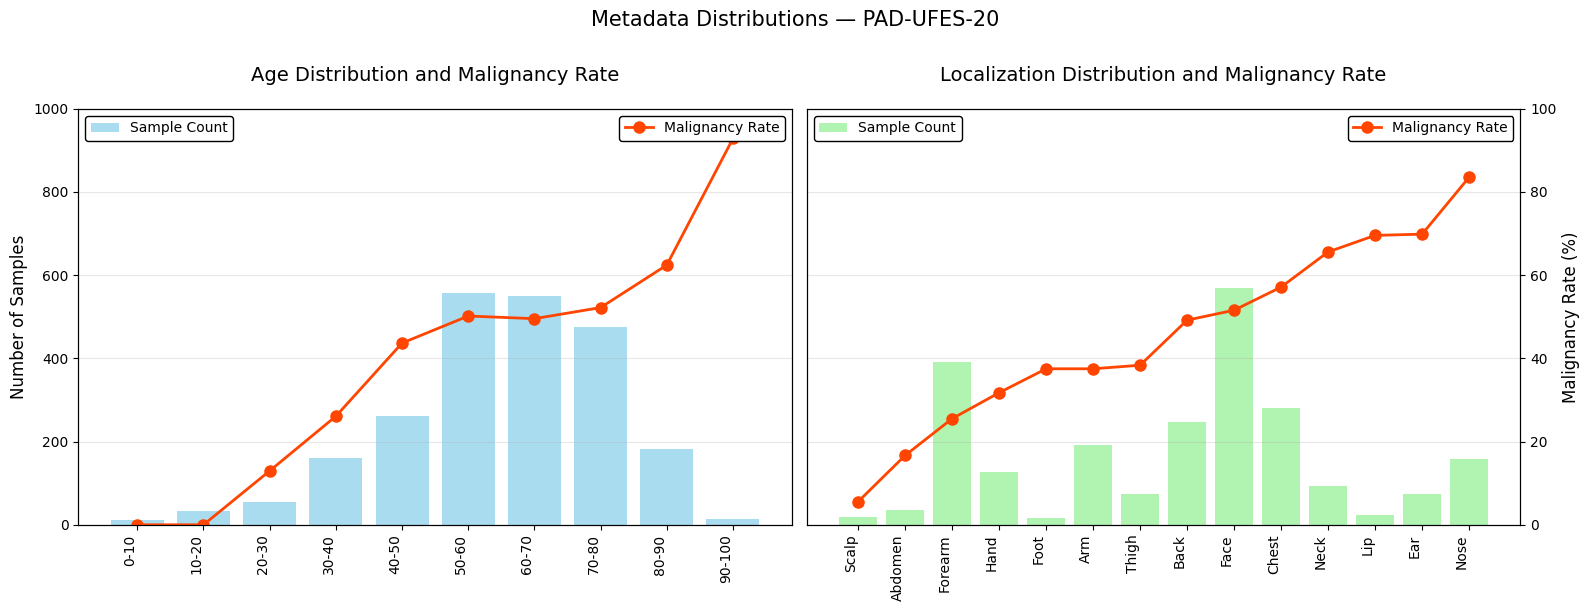

In [5]:
fig_meta = visualization.plot_metadata_distributions(meta, DANGEROUS_CLASSES, title_suffix=TITLE_SUFFIX)
plt.show()

In [6]:
fold_metrics, oof_lite, oof_heavy, oof_dynamic, route_mask_oof, route_components_oof = training.run_cv_pipeline(
    X_heavy, X_lite, X_tab, y, meta,
    class_names=CLASSES,
    safe_classes=SAFE_CLASSES,
    dangerous_classes=DANGEROUS_CLASSES,
    lite_energy_dir=LITE_DIR,
    heavy_energy_dir=HEAVY_DIR,
    n_splits=5,
    risk_scaler=risk_scaler,
)

print("\n--- Cross-Validation Results (5 Folds) ---")
print(f"Lite Accuracy:    {np.mean(fold_metrics['acc_lite']):.4f} ± {np.std(fold_metrics['acc_lite']):.4f}")
print(f"Heavy Accuracy:   {np.mean(fold_metrics['acc_heavy']):.4f} ± {np.std(fold_metrics['acc_heavy']):.4f}")
print(f"EcoFair Accuracy: {np.mean(fold_metrics['acc_dynamic']):.4f} ± {np.std(fold_metrics['acc_dynamic']):.4f}")
print(f"Routing Rate:     {np.mean(fold_metrics['routing_rate'])*100:.2f}% ± {np.std(fold_metrics['routing_rate'])*100:.2f}%")
print(f"Energy per Sample:{np.mean(fold_metrics['energy_cost']):.2f} J ± {np.std(fold_metrics['energy_cost']):.2f} J")


--- Fold 1/5 ---


I0000 00:00:1771691077.618177      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1771691081.875797      73 service.cc:152] XLA service 0x7d2484012210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771691081.875834      73 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771691082.485559      73 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771691085.421549      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.6451 | Heavy: 0.6562 | EcoFair: 0.6429 | Route: 58.0% | Energy: 0.30 J/sample

--- Fold 2/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.6194 | Heavy: 0.6644 | EcoFair: 0.6509 | Route: 58.1% | Energy: 0.30 J/sample

--- Fold 3/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.6421 | Heavy: 0.6689 | EcoFair: 0.6555 | Route: 55.0% | Energy: 0.29 J/sample

--- Fold 4/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.6566 | Heavy: 0.6586 | EcoFair: 0.6606 | Route: 56.6% | Energy: 0.30 J/sample

--- Fold 5/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.6940 | Heavy: 0.7220 | EcoFair: 0.7177 | Route: 49.8% | Energy: 0.28 J/sample

--- Cross-Validation Results (5 Folds) ---
Lite Accuracy:    0.6514 ± 0.0245
Heavy Accuracy:   0.6740 ± 0.0244
EcoFair Accuracy: 0.6655 ± 0.0267
Routing Rate:     55.51% ± 3.07%
Energy per Sample:0.29 J ± 0.01 J


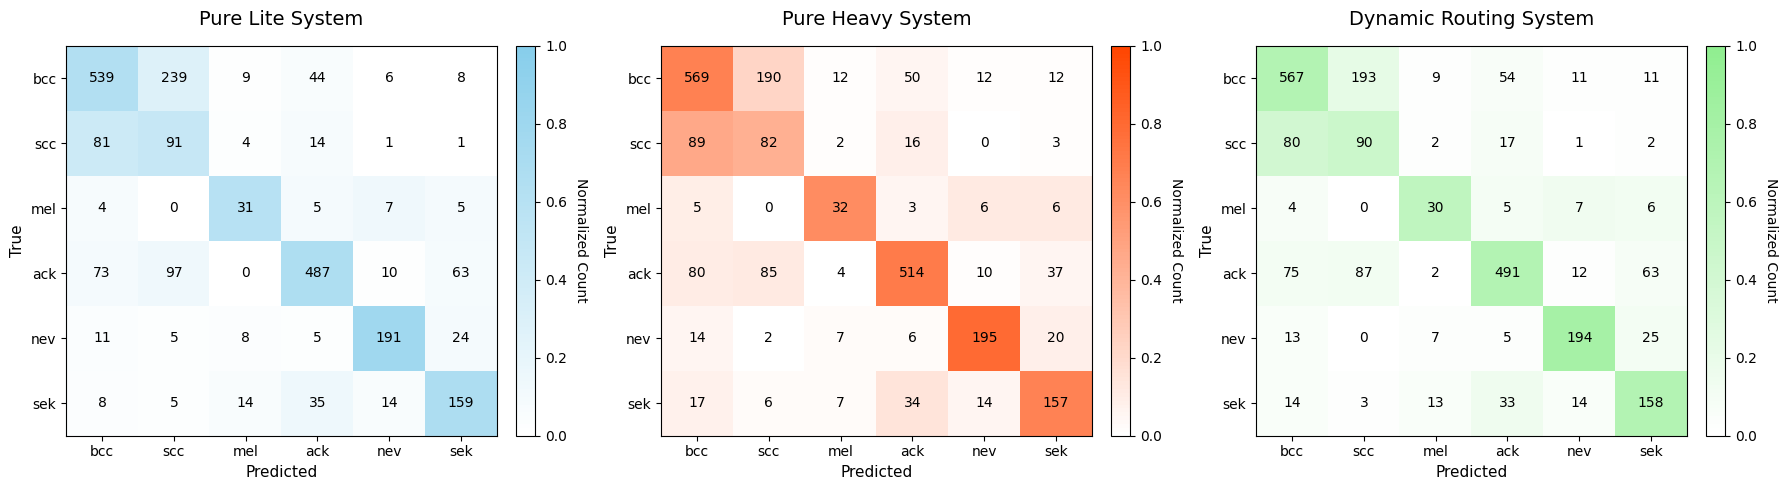

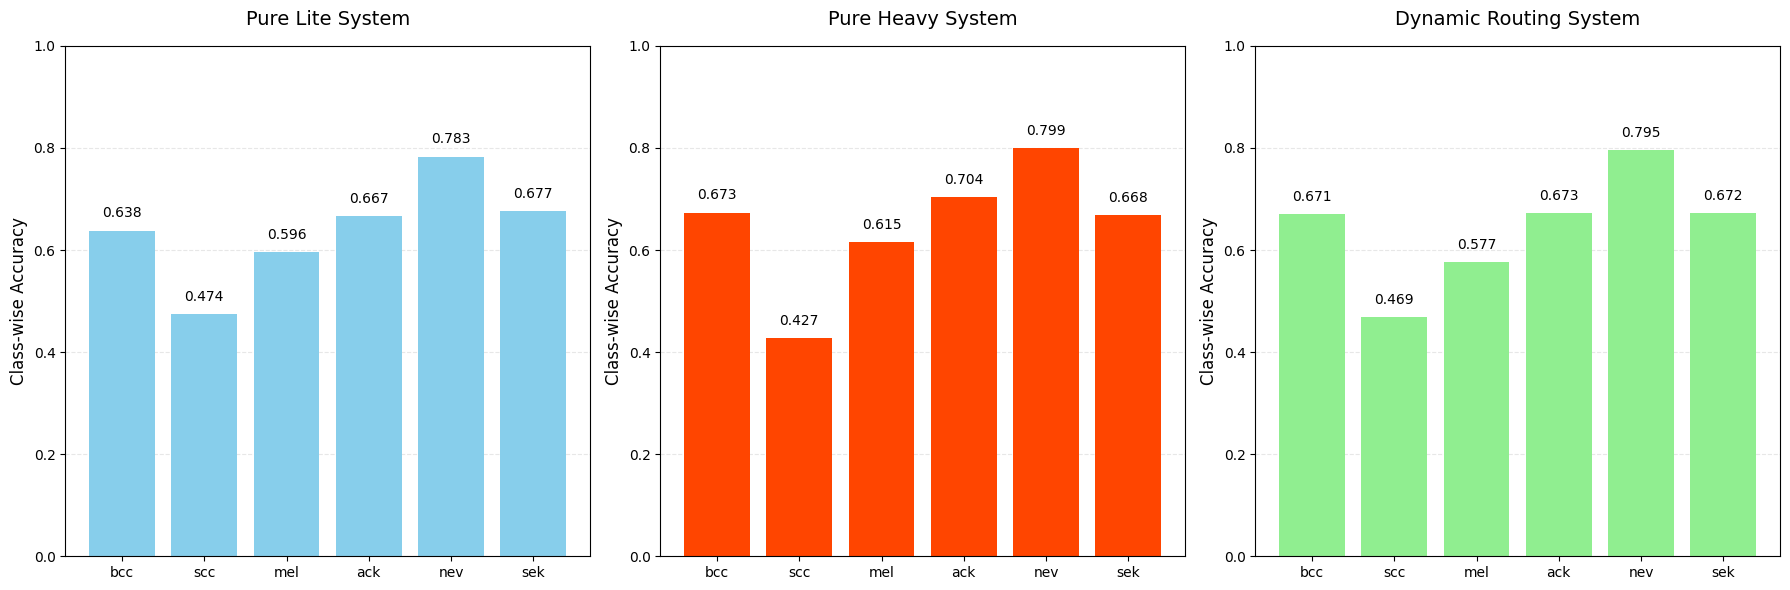

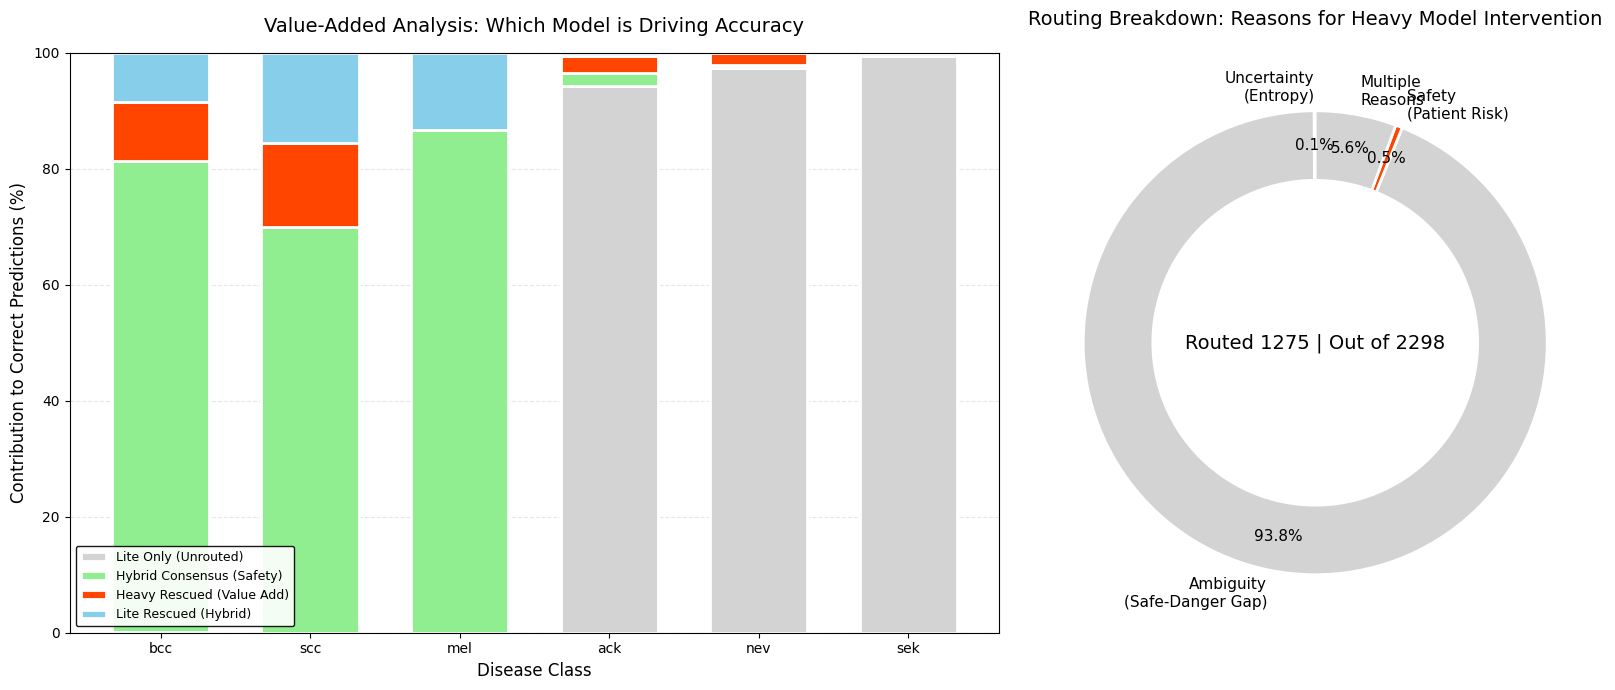

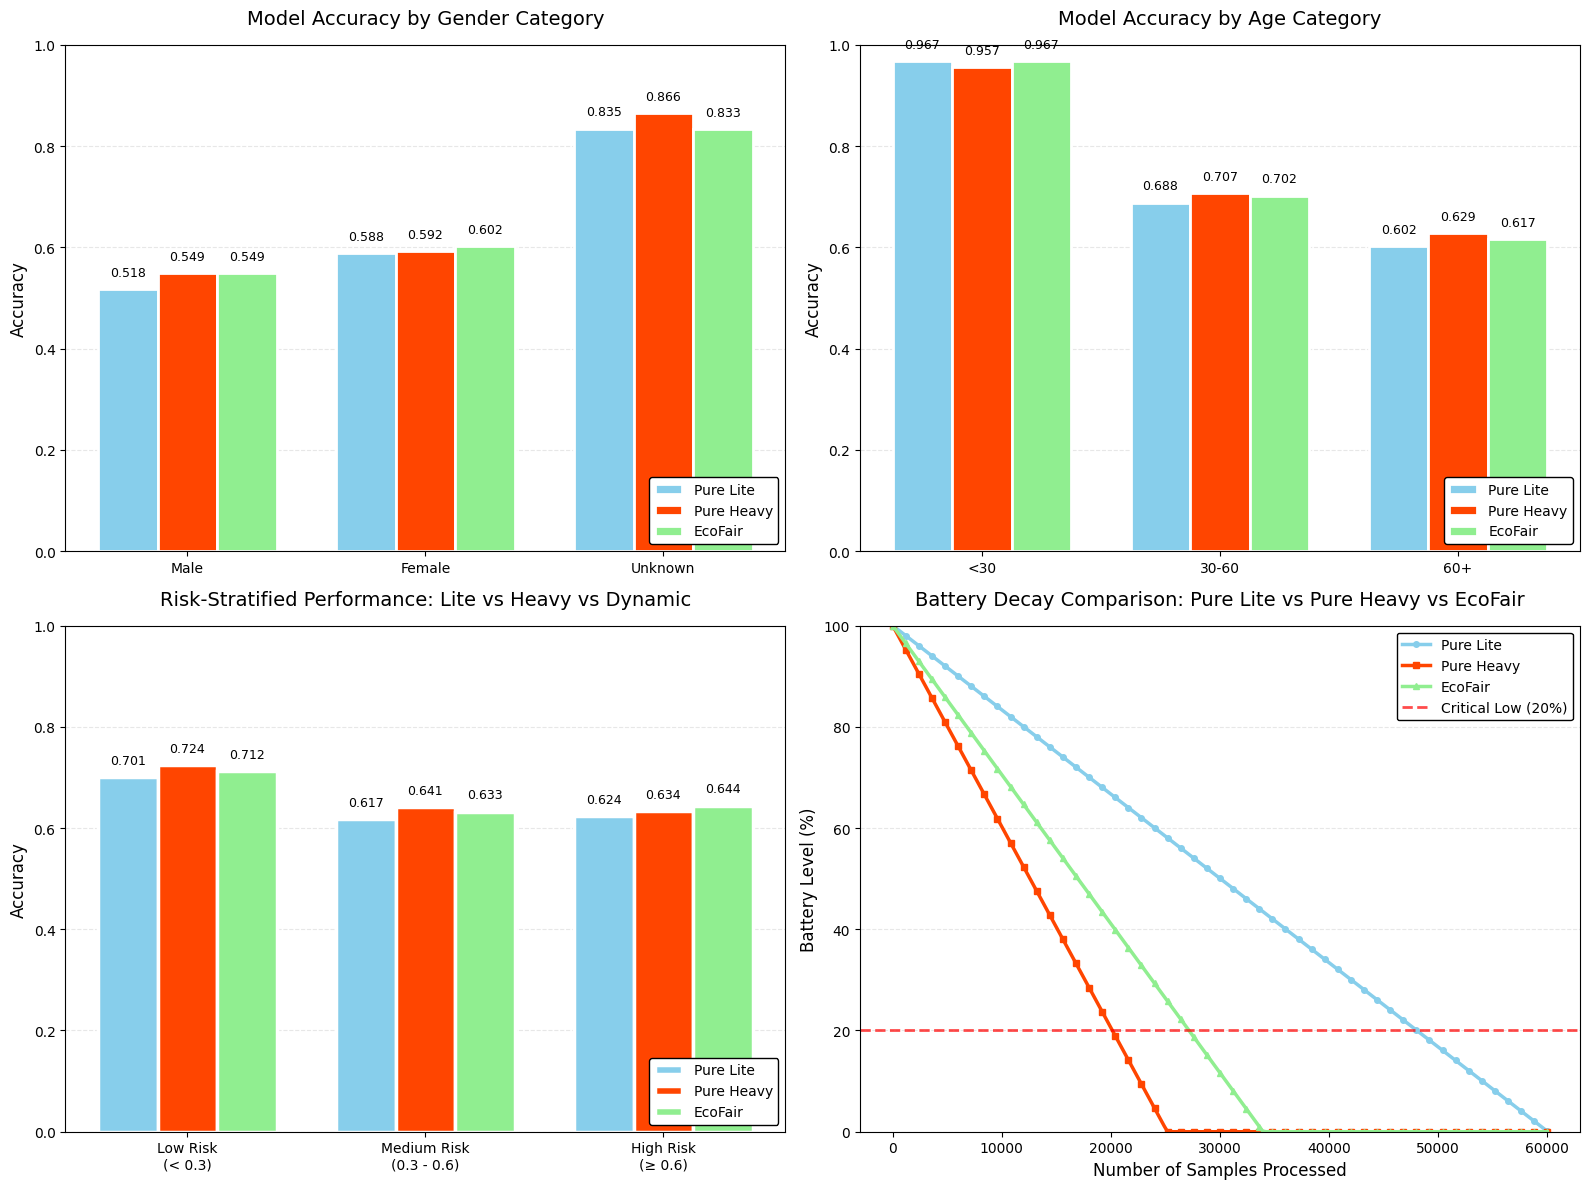

In [7]:
y_true_oof = np.argmax(y, axis=1)
entropy_oof = routing.calculate_entropy(oof_lite)
safe_indices = [CLASSES.index(c) for c in SAFE_CLASSES]
danger_indices = [CLASSES.index(c) for c in DANGEROUS_CLASSES]
prob_safe_oof = oof_lite[:, safe_indices].sum(axis=1)
prob_danger_oof = oof_lite[:, danger_indices].sum(axis=1)
safe_danger_gap_oof = prob_safe_oof - prob_danger_oof

joules_lite = utils.load_energy_stats(LITE_DIR)
joules_heavy = utils.load_energy_stats(HEAVY_DIR)
joules_lite = joules_lite if joules_lite is not None else 1.0
joules_heavy = joules_heavy if joules_heavy is not None else 2.5
routing_rate_oof = route_mask_oof.sum() / len(route_mask_oof)

fig_cm = visualization.plot_confusion_matrix_comparison(
    y_true_oof, oof_lite, oof_heavy, oof_dynamic, CLASSES
)
plt.show()

fig_classwise = visualization.plot_classwise_accuracy_bars(
    y_true_oof, oof_lite, oof_heavy, oof_dynamic, CLASSES
)
plt.show()

fig_va_doughnut, axes_va_doughnut = plt.subplots(1, 2, figsize=(18, 7))
visualization.plot_value_added_bars(
    y_true_oof, oof_lite, oof_heavy, oof_dynamic, CLASSES,
    route_mask=route_mask_oof, ax=axes_va_doughnut[0]
)
visualization.plot_routing_breakdown_doughnut(
    entropy_oof, safe_danger_gap_oof, route_mask_oof, len(route_mask_oof),
    ax=axes_va_doughnut[1], route_components=route_components_oof
)
plt.tight_layout()
plt.show()

try:
    fig_comprehensive, axes_comprehensive = plt.subplots(2, 2, figsize=(16, 12))
    visualization.plot_gender_age_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta, CLASSES,
        axes=(axes_comprehensive[0, 0], axes_comprehensive[0, 1])
    )
    visualization.plot_risk_stratified_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta,
        risk_scaler=risk_scaler, ax=axes_comprehensive[1, 0]
    )
    visualization.plot_battery_decay(
        joules_lite, joules_heavy, routing_rate_oof, capacity_joules=10000,
        ax=axes_comprehensive[1, 1]
    )
    plt.tight_layout()
    plt.show()
except TypeError:
    try:
        plt.close(fig_comprehensive)
    except NameError:
        pass
    fig_gender_age = visualization.plot_gender_age_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta, CLASSES
    )
    plt.show()
    fig_risk_battery, axes_risk_battery = plt.subplots(1, 2, figsize=(20, 6))
    visualization.plot_risk_stratified_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta,
        risk_scaler=risk_scaler, ax=axes_risk_battery[0]
    )
    visualization.plot_battery_decay(
        joules_lite, joules_heavy, routing_rate_oof, capacity_joules=10000,
        ax=axes_risk_battery[1]
    )
    plt.tight_layout()
    plt.show()


--- Subgroup Accuracy ---
Class                  ack    bcc    mel    nev    scc    sek
Subgroup                                                     
Age 30-60 (n=978)   0.8538 0.8282 0.9765 0.9254 0.9090 0.9223
Age 60+ (n=1221)    0.8288 0.7584 0.9754 0.9861 0.7576 0.9124
Age <30 (n=99)      0.9899 0.9899 0.9798 0.9495 1.0000 0.9899
Sex: Female (n=753) 0.8207 0.7278 0.9602 0.9562 0.7928 0.9456
Sex: Male (n=741)   0.8421 0.6505 0.9676 0.9771 0.6910 0.9703

--- Equal Opportunity (True Positive Rate) ---
Goal: TPR should be roughly equal across subgroups for the same class.
'-' indicates no actual cases of that class in the subgroup.
Class                  ack    bcc    mel    nev    scc    sek
Subgroup                                                     
Age 30-60 (n=978)   0.7395 0.7645 0.6667 0.7429 0.2128 0.5362
Age 60+ (n=1221)    0.6177 0.5992 0.5217 0.0000 0.5517 0.7333
Age <30 (n=99)      0.0000 0.8000 0.0000 1.0000      - 0.0000
Sex: Female (n=753) 0.4575 0.6995 0.5000 0.6735 0

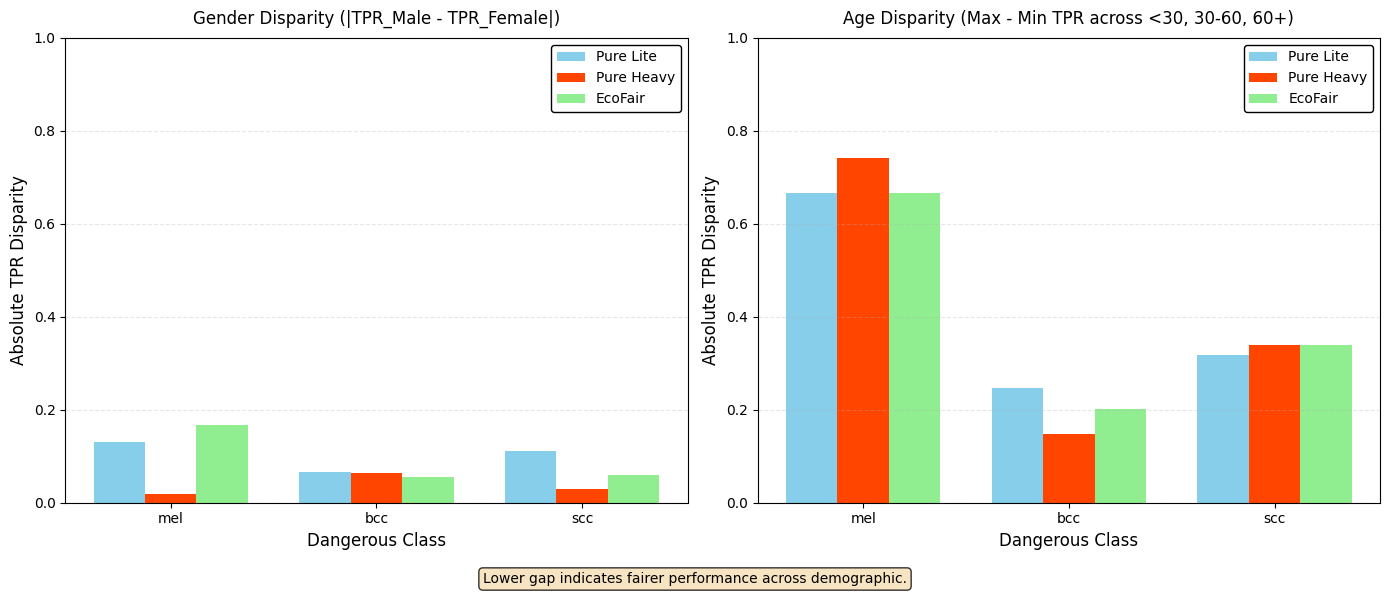

In [8]:
y_true_labels = np.argmax(y, axis=1)
lite_pred_labels = np.argmax(oof_lite, axis=1)
heavy_pred_labels = np.argmax(oof_heavy, axis=1)
dynamic_pred_labels = np.argmax(oof_dynamic, axis=1)

fairness_ecofair = fairness.generate_fairness_report(
    y_true_labels, dynamic_pred_labels, meta, CLASSES
)
fairness_lite = fairness.generate_fairness_report(
    y_true_labels, lite_pred_labels, meta, CLASSES
)
fairness_heavy = fairness.generate_fairness_report(
    y_true_labels, heavy_pred_labels, meta, CLASSES
)

fairness.print_fairness_audit(fairness_ecofair)
visualization.plot_fairness_disparity(
    fairness_lite, fairness_heavy, fairness_ecofair, DANGEROUS_CLASSES
)
plt.show()